# Validation of HMASR with snow depth stations
## Spatial snow depth

- HMASR: [High Mountain Asia UCLA Daily Snow Reanalysis, Version 1](https://nsidc.org/data/HMA_SR_D)
- snow depth stations: [Observational snow depth dataset of the Tibetan Plateau (Version 1.0) (1961-2013)](https://data.tpdc.ac.cn/en/data/72d6dadf-8e1c-458b-b24e-91539042dfe6/)

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '../utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Load topography

In [54]:
latlim = slice(27, 45)
lonlim = slice(61, 105)

ds = xr.open_dataset('../data/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim, lon=lonlim)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load stations

In [3]:
path = '../data/in-situ_SD_TP_v1.0_1961-2013/'

df_loc = pd.read_csv(path+'Tibetan_Plateau_Snow_Depth_1961-2013.txt', delimiter='\t')
df_loc.set_index('numb', inplace=True)
df_loc

,prov,name_en,name_cn,latit,longit,elevat
numb,,,,,,
52787,甘肃,S52787,乌鞘岭,37.200000,102.866667,3045.1
52978,甘肃,S52978,夏河,35.200000,102.516667,2929.4
56071,甘肃,S56071,碌曲,34.583333,102.500000,3105.7
56074,甘肃,S56074,玛曲,34.000000,102.083333,3471.4
56080,甘肃,S56080,合作,35.000000,102.900000,2910.0
...,...,...,...,...,...,...
56434,西藏,S56434,察隅,28.650000,97.466667,2327.6
56444,云南,S56444,德钦,28.483333,98.916667,3319.0
56533,云南,S56533,贡山,27.750000,98.666667,1583.3


## Load timseries data 
Saved in `HMASR_validation_with_TPDC_SD_stations.ipynb`

In [4]:
df_station_HMASR = pd.read_csv('data/HMASR_validation_with_TPDC_SD_stations.csv', header=[0, 1], index_col=0, parse_dates=True)
df_station_HMASR = df_station_HMASR.where(df_station_HMASR >= 0) # to avoid some negative values
df_station_HMASR

numb         52787         52978         56071         56074         56080  \
product    station HMASR station HMASR station HMASR station HMASR station   
date                                                                         
1999-10-01     NaN  0.00     0.0  0.04     0.0  0.18     0.0  0.26     0.0   
1999-10-02     4.0  0.00     0.0  0.04     0.0  0.34     0.0  0.46     0.0   
1999-10-03     0.0  0.06     0.0  0.28     0.0  0.52     0.0  0.52     0.0   
1999-10-04     2.0  0.00     0.0  0.24     0.0  0.78     0.0  1.18     0.0   
1999-10-05     0.0  0.00     0.0  0.10     0.0  0.54     0.0  1.86     0.0   
...            ...   ...     ...   ...     ...   ...     ...   ...     ...   
2013-12-27     0.0  0.82     0.0  2.20     0.0  0.00     0.0  0.04     0.0   
2013-12-28     0.0  0.82     0.0  2.18     0.0  0.00     0.0  0.04     0.0   
2013-12-29     0.0  0.80     0.0  2.16     0.0  0.00     0.0  0.04     0.0   
2013-12-30     0.0  0.78     0.0  2.10     0.0  0.00     0.0  0.04     0.0   
2013-12-31     0.0  0.78     0.0  2.04     0.0  0.00     0.0  0.04     0.0   

numb              ...   56434         56444         56533         56543        \
product    HMASR  ... station HMASR station HMASR station HMASR station HMASR   
date              ...                                                           
1999-10-01   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-02   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-03   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-04   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-05   0.0  ...     0.0  0.00     0.0   0.0     0.0   0.0     0.0   0.0   
...          ...  ...     ...   ...     ...   ...     ...   ...     ...   ...   
2013-12-27   0.0  ...     0.0  5.88     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-28   0.0  ...     0.0  6.50     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-29   0.0  ...     0.0  8.70     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-30   0.0  ...     0.0  7.42     0.0   0.0     0.0   0.0     0.0   0.0   
2013-12-31   0.0  ...     0.0  5.84     0.0   0.0     0.0   0.0     0.0   0.0   

numb         56641        
product    station HMASR  
date                      
1999-10-01     NaN   NaN  
1999-10-02     NaN   NaN  
1999-10-03     NaN   NaN  
1999-10-04     NaN   NaN  
1999-10-05     NaN   NaN  
...            ...   ...  
2013-12-27     NaN   NaN  
2013-12-28     NaN   NaN  
2013-12-29     NaN   NaN  
2013-12-30     NaN   NaN  
2013-12-31     NaN   NaN  

[5206 rows x 204 columns]

### Get >90% time coverage and >1mm in DJFMA
We are going to make some criteria for taking stations, as many stations doesn't have much snow, so for example we can take stations that have a minimum of snow in winter (ex: 1mm threshold) + taking only stations that have more than 90% of data for example.

In [5]:
# Remove stations with less than 90% of data
df_station_HMASR_90 = df_station_HMASR.dropna(thresh=df_station_HMASR.index.size*0.9, axis=1)

temp = df_station_HMASR_90.xs('station', axis=1, level='product').resample('m').mean()
winter_mask = ((temp.index.month > 11) | (temp.index.month < 5))

# Take stations having at least 1mm of snow in winter (DJFMA)
mm_mask = temp[winter_mask].mean() > 0.1

# Index of the 62 corresponding stations (> 1mm in winter)
index_1mm = mm_mask[mm_mask == True].index

df_station_HMASR_90_1mm = df_station_HMASR_90[index_1mm]
df_station_HMASR_90_1mm

numb         52787         52978         56071         56074         56080  \
product    station HMASR station HMASR station HMASR station HMASR station   
date                                                                         
1999-10-01     NaN  0.00     0.0  0.04     0.0  0.18     0.0  0.26     0.0   
1999-10-02     4.0  0.00     0.0  0.04     0.0  0.34     0.0  0.46     0.0   
1999-10-03     0.0  0.06     0.0  0.28     0.0  0.52     0.0  0.52     0.0   
1999-10-04     2.0  0.00     0.0  0.24     0.0  0.78     0.0  1.18     0.0   
1999-10-05     0.0  0.00     0.0  0.10     0.0  0.54     0.0  1.86     0.0   
...            ...   ...     ...   ...     ...   ...     ...   ...     ...   
2013-12-27     0.0  0.82     0.0  2.20     0.0  0.00     0.0  0.04     0.0   
2013-12-28     0.0  0.82     0.0  2.18     0.0  0.00     0.0  0.04     0.0   
2013-12-29     0.0  0.80     0.0  2.16     0.0  0.00     0.0  0.04     0.0   
2013-12-30     0.0  0.78     0.0  2.10     0.0  0.00     0.0  0.04     0.0   
2013-12-31     0.0  0.78     0.0  2.04     0.0  0.00     0.0  0.04     0.0   

numb              ...   56223         56434         56444         56533        \
product    HMASR  ... station HMASR station HMASR station HMASR station HMASR   
date              ...                                                           
1999-10-01   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-02   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-03   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-04   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
1999-10-05   0.0  ...     0.0  0.00     0.0  0.00     0.0   0.0     0.0   0.0   
...          ...  ...     ...   ...     ...   ...     ...   ...     ...   ...   
2013-12-27   0.0  ...     0.0  0.30     0.0  5.88     0.0   0.0     0.0   0.0   
2013-12-28   0.0  ...     0.0  0.28     0.0  6.50     0.0   0.0     0.0   0.0   
2013-12-29   0.0  ...     0.0  0.30     0.0  8.70     0.0   0.0     0.0   0.0   
2013-12-30   0.0  ...     0.0  0.30     0.0  7.42     0.0   0.0     0.0   0.0   
2013-12-31   0.0  ...     0.0  0.30     0.0  5.84     0.0   0.0     0.0   0.0   

numb         56543        
product    station HMASR  
date                      
1999-10-01     0.0   0.0  
1999-10-02     0.0   0.0  
1999-10-03     0.0   0.0  
1999-10-04     0.0   0.0  
1999-10-05     0.0   0.0  
...            ...   ...  
2013-12-27     0.0   0.0  
2013-12-28     0.0   0.0  
2013-12-29     0.0   0.0  
2013-12-30     0.0   0.0  
2013-12-31     0.0   0.0  

[5206 rows x 124 columns]

## Get monthly spatial SD (at 5km)

In [117]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:38931 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.00 GB


In [1]:
client.close()

NameError: name 'client' is not defined

In [119]:
# Sélectionner toutes les années 1999-10-01 à 2013-12-31 pour faire correspondre aux stations
# Montly averaged data (so the timestamp is at the end of the month -> 1999-10-31 = mean(1999-10-01 to 1999-10-31))

# path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M/WY1999_00/'
path = '/mnt/lalandmi/equipes/C2H/HMASR/HMA_SR_M/'

In [120]:
ds = xr.open_mfdataset(path+'/*/*SD*', parallel=True)
ds

,Array,Chunk
Bytes,356.40 MB,30.00 kB
Shape,"(180, 450, 1100)","(12, 25, 25)"
Count,81763 Tasks,11880 Chunks
Type,float32,numpy.ndarray


In [126]:
# Define common period
period = slice('1999-10-01','2013-12-31')
sd = ds.sel(time=period).SD_Post.load()*100 # convert m to cm

In [68]:
# sd_annual = ds.SD_Post.mean('time').compute()*100
# sd_winter = ds.SD_Post.where( (ds['time.month'] == 12) | (ds['time.month'] < 5) ).mean('time').compute()*100 # DJFMA
# sd_summer = ds.SD_Post.where( (ds['time.month'] > 5 ) & (ds['time.month'] < 10) ).mean('time').compute()*100 # JJAS

In [135]:
sd_annual = sd.mean('time')
sd_winter = sd.where( (ds['time.month'] == 12) | (ds['time.month'] < 5) ).mean('time') # DJFMA
sd_summer = sd.where( (ds['time.month'] > 5 ) & (ds['time.month'] < 10) ).mean('time') # JJAS

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Plot

In [131]:
df_station_HMASR_90_1mm

numb         52787            52978            56071         56074           \
product    station    HMASR station    HMASR station HMASR station    HMASR   
date                                                                          
1999-10-01     NaN  0.0e+00     0.0  4.0e-02     0.0   0.2     0.0  2.6e-01   
1999-10-02     4.0  0.0e+00     0.0  4.0e-02     0.0   0.3     0.0  4.6e-01   
1999-10-03     0.0  6.0e-02     0.0  2.8e-01     0.0   0.5     0.0  5.2e-01   
1999-10-04     2.0  0.0e+00     0.0  2.4e-01     0.0   0.8     0.0  1.2e+00   
1999-10-05     0.0  0.0e+00     0.0  1.0e-01     0.0   0.5     0.0  1.9e+00   
...            ...      ...     ...      ...     ...   ...     ...      ...   
2013-12-27     0.0  8.2e-01     0.0  2.2e+00     0.0   0.0     0.0  4.0e-02   
2013-12-28     0.0  8.2e-01     0.0  2.2e+00     0.0   0.0     0.0  4.0e-02   
2013-12-29     0.0  8.0e-01     0.0  2.2e+00     0.0   0.0     0.0  4.0e-02   
2013-12-30     0.0  7.8e-01     0.0  2.1e+00     0.0   0.0     0.0  4.0e-02   
2013-12-31     0.0  7.8e-01     0.0  2.0e+00     0.0   0.0     0.0  4.0e-02   

numb         56080        ...   56223         56434         56444        \
product    station HMASR  ... station HMASR station HMASR station HMASR   
date                      ...                                             
1999-10-01     0.0   0.0  ...     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-02     0.0   0.0  ...     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-03     0.0   0.0  ...     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-04     0.0   0.0  ...     0.0   0.0     0.0   0.0     0.0   0.0   
1999-10-05     0.0   0.0  ...     0.0   0.0     0.0   0.0     0.0   0.0   
...            ...   ...  ...     ...   ...     ...   ...     ...   ...   
2013-12-27     0.0   0.0  ...     0.0   0.3     0.0   5.9     0.0   0.0   
2013-12-28     0.0   0.0  ...     0.0   0.3     0.0   6.5     0.0   0.0   
2013-12-29     0.0   0.0  ...     0.0   0.3     0.0   8.7     0.0   0.0   
2013-12-30     0.0   0.0  ...     0.0   0.3     0.0   7.4     0.0   0.0   
2013-12-31     0.0   0.0  ...     0.0   0.3     0.0   5.8     0.0   0.0   

numb         56533         56543        
product    station HMASR station HMASR  
date                                    
1999-10-01     0.0   0.0     0.0   0.0  
1999-10-02     0.0   0.0     0.0   0.0  
1999-10-03     0.0   0.0     0.0   0.0  
1999-10-04     0.0   0.0     0.0   0.0  
1999-10-05     0.0   0.0     0.0   0.0  
...            ...   ...     ...   ...  
2013-12-27     0.0   0.0     0.0   0.0  
2013-12-28     0.0   0.0     0.0   0.0  
2013-12-29     0.0   0.0     0.0   0.0  
2013-12-30     0.0   0.0     0.0   0.0  
2013-12-31     0.0   0.0     0.0   0.0  

[5206 rows x 124 columns]

In [132]:
# Resample station by month and apply mask for seasons
temp = df_station_HMASR_90_1mm.xs('station', axis=1, level='product').resample('m').mean()
winter_mask = ((temp.index.month > 11) | (temp.index.month < 5))
summer_mask = ((temp.index.month > 5) & (temp.index.month < 10))

# Take stations having at least 1mm of snow in winter (DJFMA)
df_annual = temp.mean()
df_winter = temp[winter_mask].mean()
df_summer = temp[summer_mask].mean()

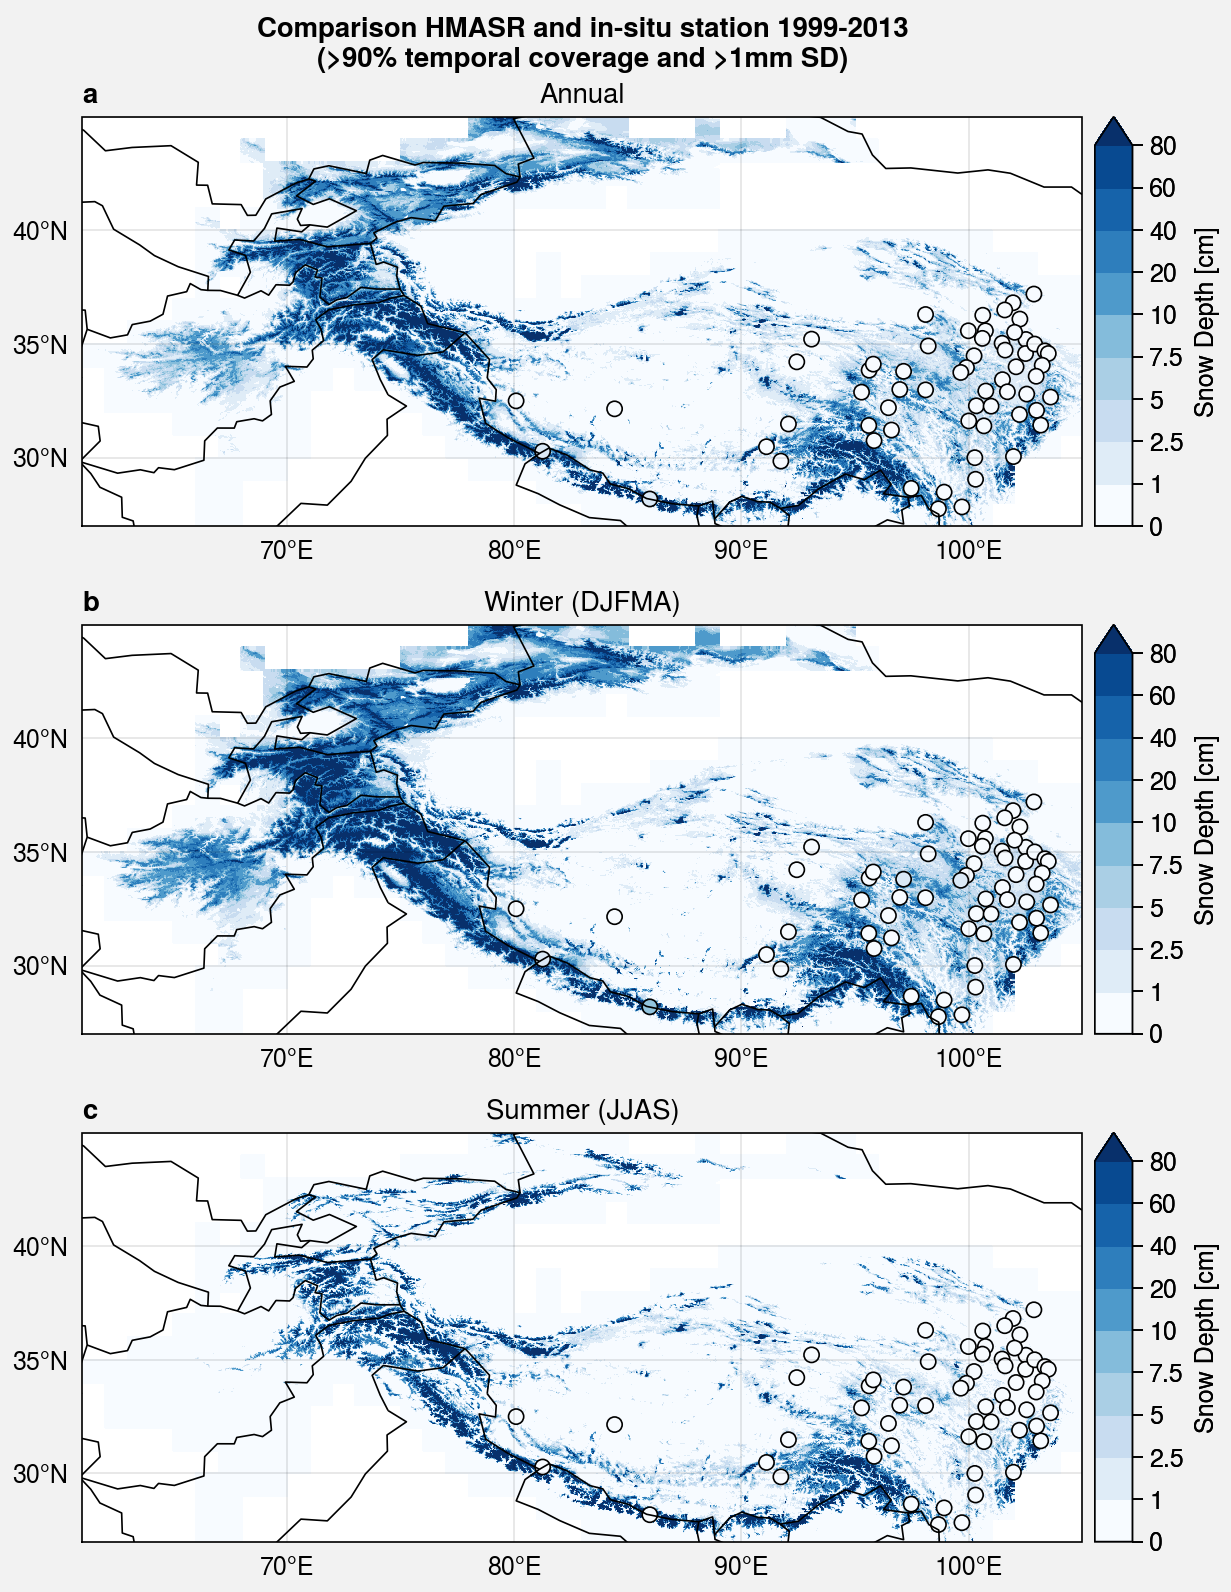

In [137]:
cmap='Blues'
# levels=plot.arange(0,100,10)
levels=[0, 1, 2.5, 5, 7.5, 10, 20, 40, 60, 80]
extend='max'
markersize=30
pd.set_option("display.precision", 1)

fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5, share=0)

# Plot topography (HMA + zoom)

df_list = [df_annual, df_winter, df_summer]
sd_list = [sd_annual, sd_winter, sd_summer]

for i, ax in enumerate(axs):
    ax.pcolormesh(sd_list[i], colorbar='r', cmap=cmap, levels=levels, extend=extend, colorbar_kw={'label': 'Snow Depth [cm]'})
    ax.scatter(
        df_loc.loc[index_1mm.to_numpy().astype(np.int)].longit.values, 
        df_loc.loc[index_1mm.to_numpy().astype(np.int)].latit.values, 
        markersize=markersize, marker='o', color=df_list[i], 
        cmap=cmap, edgecolors='black', levels=levels
    )

    
# Format   
axs.format(
    suptitle='Comparison HMASR and in-situ station 1999-2013\n(>90% temporal coverage and >1mm SD)',
    abc=True,
    borders=True, labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
)


titles = [
    'Annual',
    'Winter (DJFMA)',
    'Summer (JJAS)'
]
for i, ax in enumerate(axs):
    ax.format(title=titles[i])

fig.save('img/spatial_SD_comparison_HMASR_station_averaged_90_1mm.jpg')

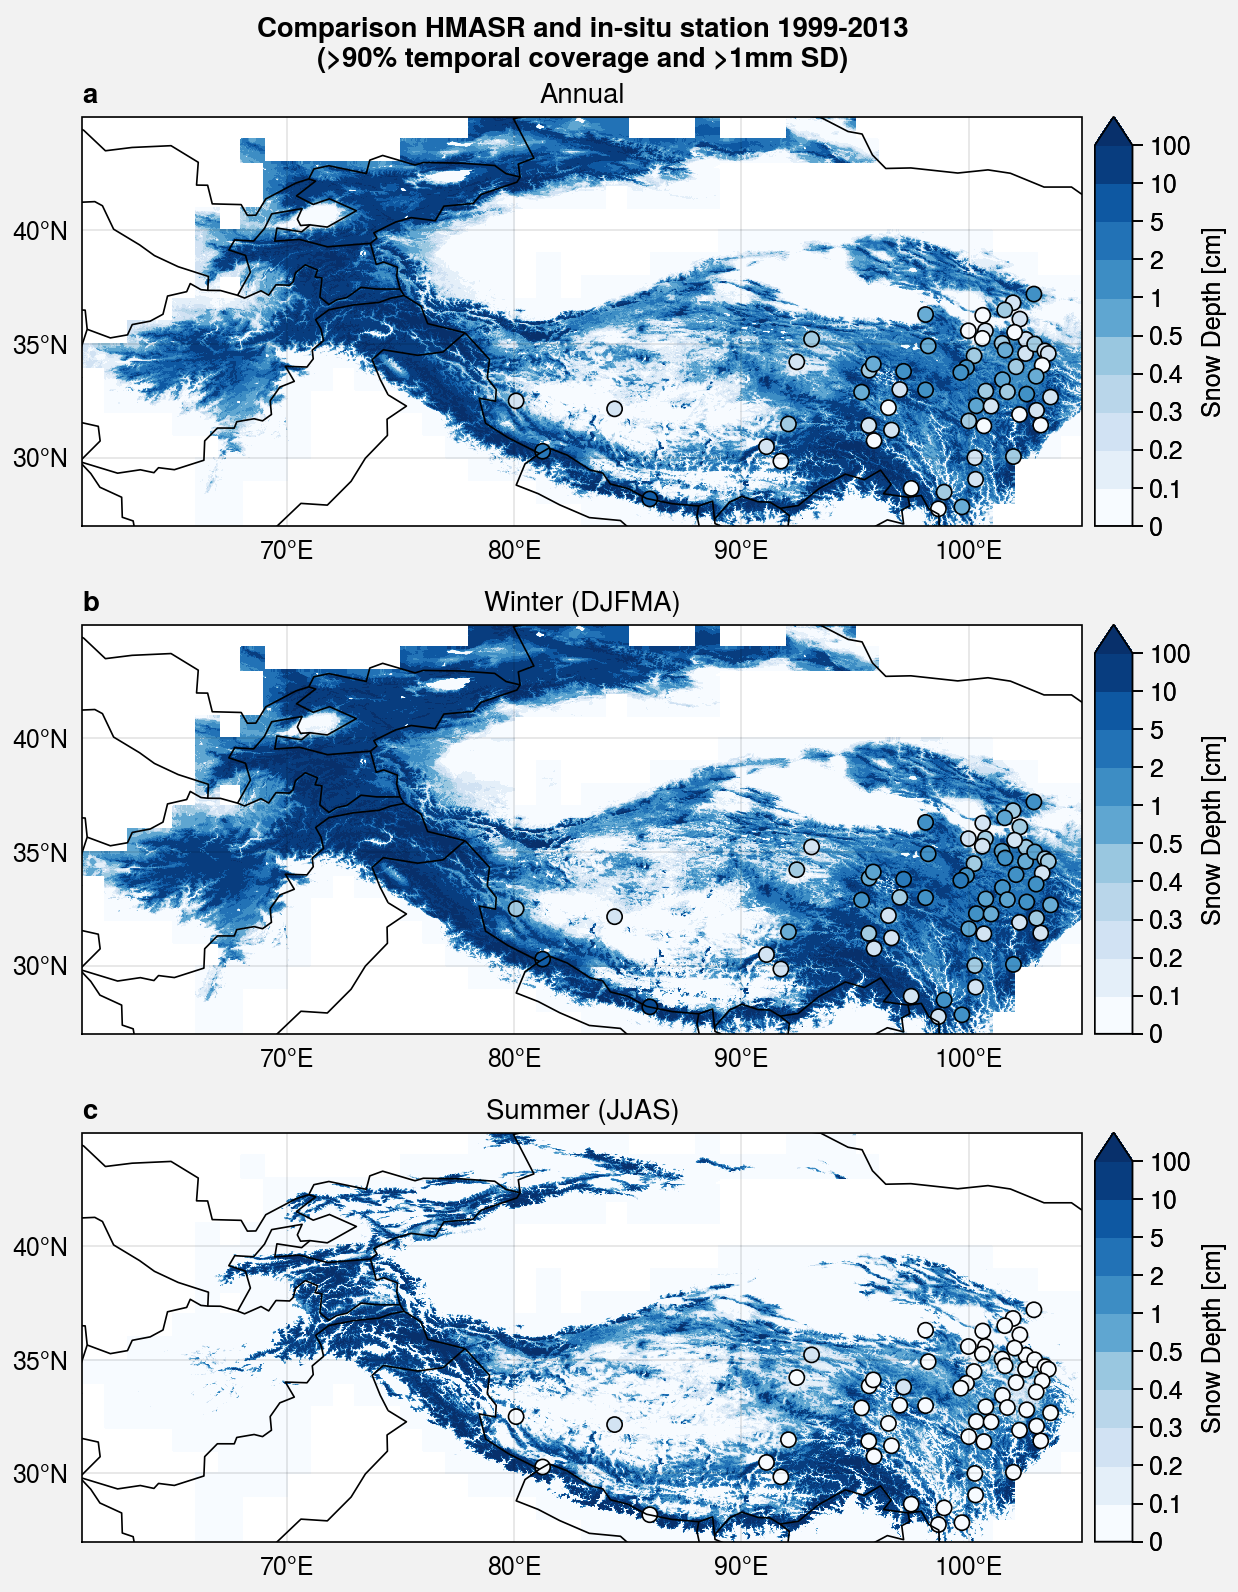

In [138]:
cmap='Blues'
levels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 10, 100]
extend='max'
markersize=30
pd.set_option("display.precision", 1)

fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5, share=0)

# Plot topography (HMA + zoom)

df_list = [df_annual, df_winter, df_summer]
sd_list = [sd_annual, sd_winter, sd_summer]

for i, ax in enumerate(axs):
    ax.pcolormesh(sd_list[i], colorbar='r', cmap=cmap, levels=levels, extend=extend, colorbar_kw={'label': 'Snow Depth [cm]'})
    ax.scatter(
        df_loc.loc[index_1mm.to_numpy().astype(np.int)].longit.values, 
        df_loc.loc[index_1mm.to_numpy().astype(np.int)].latit.values, 
        markersize=markersize, marker='o', color=df_list[i], 
        cmap=cmap, edgecolors='black', levels=levels
    )

    
# Format   
axs.format(
    suptitle='Comparison HMASR and in-situ station 1999-2013\n(>90% temporal coverage and >1mm SD)',
    abc=True,
    borders=True, labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
)


titles = [
    'Annual',
    'Winter (DJFMA)',
    'Summer (JJAS)'
]
for i, ax in enumerate(axs):
    ax.format(title=titles[i])

fig.save('img/spatial_SD_comparison_HMASR_station_averaged_90_1mm_2.jpg')